In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.

from tqdm import tqdm
import seaborn as sns

In [3]:
#先看一下label文件的内容是什么样子的
labels_dataframe=pd.read_csv('../classify-leaves/train.csv')
labels_dataframe.head(10)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera
5,images/5.jpg,maclura_pomifera
6,images/6.jpg,ulmus_rubra
7,images/7.jpg,broussonettia_papyrifera
8,images/8.jpg,maclura_pomifera
9,images/9.jpg,broussonettia_papyrifera


In [4]:
#接下来看看image和label的总个数和类别数以及出现频率最高的值和其出现的次数
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


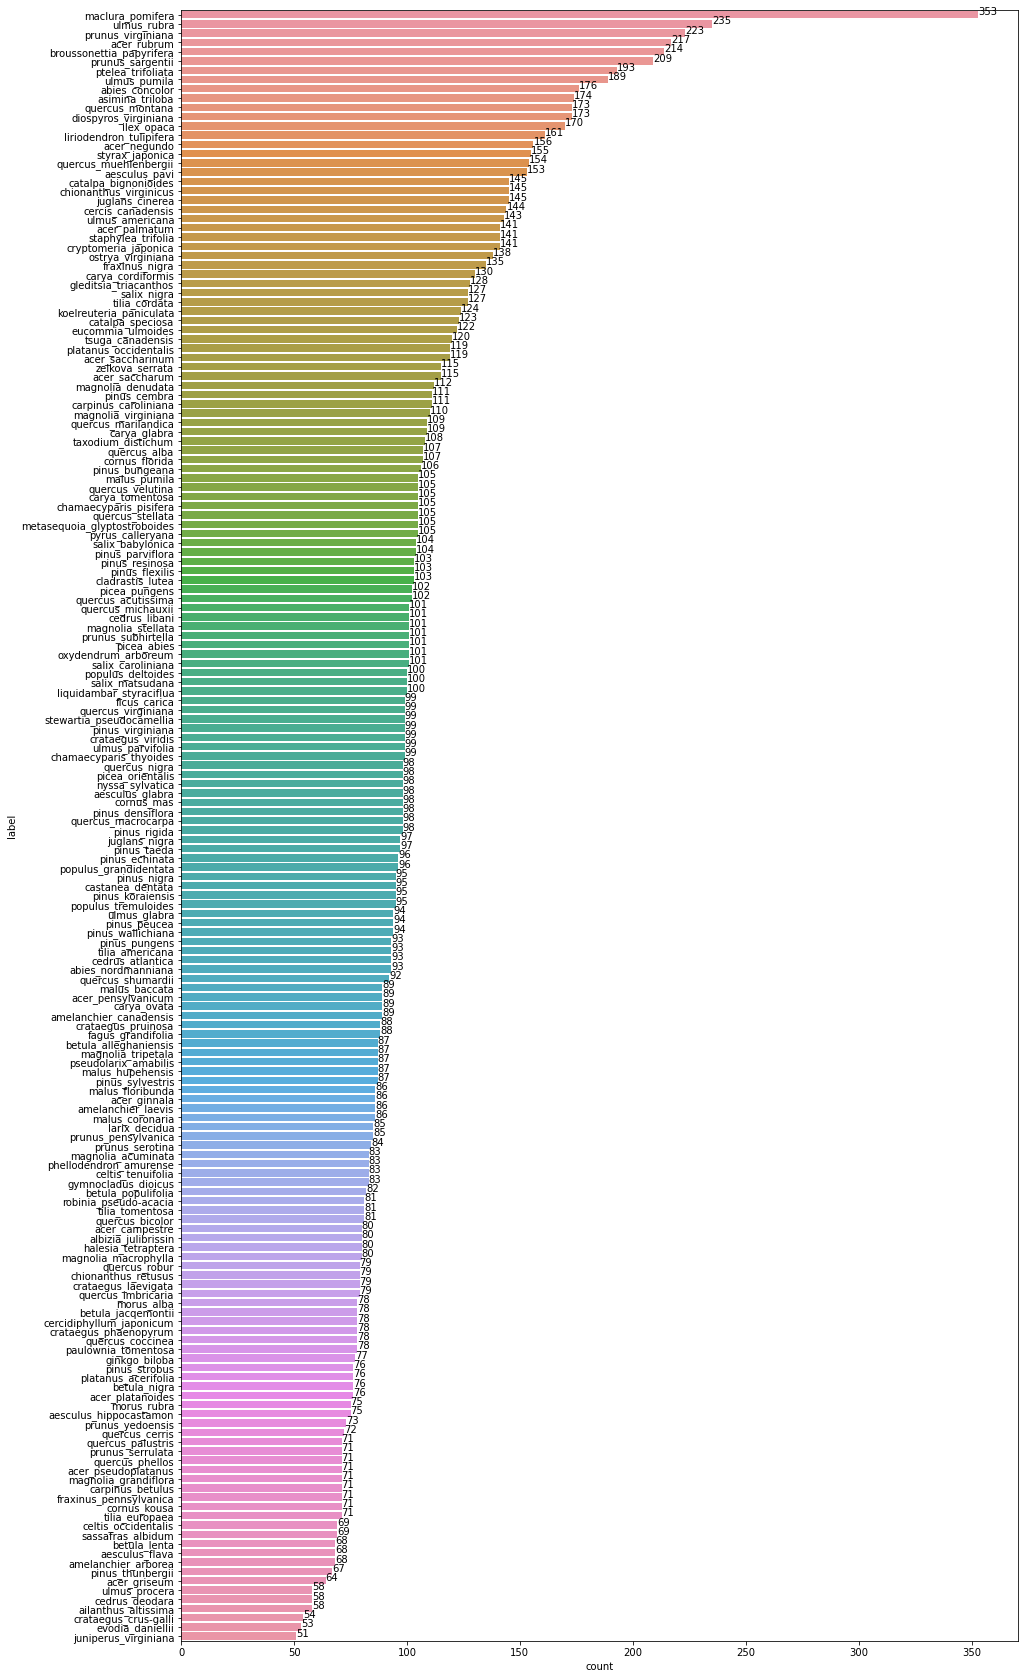

In [5]:
#接下来定义展示标签总数的条状图的函数
def barw(ax):
    for p in ax.patches:
        #获取当前元素的宽度
        val=p.get_width()
        #获取该点的x轴对应的值
        x=p.get_x()+p.get_width()
        #获取该点的y轴对应的值
        y=p.get_y()+p.get_height()/2
        #在图上画出该店的位置并且形成柱状图
        ax.annotate(round(val,2),(x,y))

#画出各个叶子类型的个数图并且排序
plt.figure(figsize=(15,30))
ax0=sns.countplot(y=labels_dataframe['label'],order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()


In [6]:
#把label文件进行一个排序
#这里用了一个set是为了将相同的类型只出现一次 这是python中的数据结构
leaves_labels=sorted(list(set(labels_dataframe['label'])))
n_classes=len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [7]:
#然后把label转换成对应的数字
class_to_num=dict(zip(leaves_labels,range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [8]:
#然后再把它们转换回来 方便最后预测的时候调用
num_to_class={v:k for k,v in class_to_num.items()}

In [9]:
#继承一下pytorch的dataset 然后创建自己的新的数据集类
class LeavesData(Dataset):
    #定义初始化函数
    def __init__(self,csv_path,file_path,mode='train',valid_ratio=0.2,
                resize_height=256,resize_width=256) -> None:
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        super().__init__()
        #对类中的参数进行初始化
        self.resize_height=resize_height
        self.resize_width=resize_width

        self.file_path=file_path
        self.mode=mode

        #读取csv文件
        self.data_info=pd.read_csv(csv_path,header=None)#这里要去掉表头
        #计算数据的长度
        self.data_len=len(self.data_info.index)-1#因为表头没有设为header所以需要把表头去掉
        self.train_len=int(self.data_len*(1-valid_ratio))

        #如果是在训练模式下的话
        if mode=='train':
            #dataframe中的第一列是图像的名称 将他拿出来放到array中 由于header=none 所以真实的数据在索引为1的行
            self.train_image=np.asarray(self.data_info.iloc[1:self.train_len,0])
            #第二列是图像的标签
            self.train_label=np.asarray(self.data_info.iloc[1:self.train_len,1])

            self.image_arr=self.train_image
            self.label_arr=self.train_label
        #如果实在验证模式的情况下
        elif mode=='valid':
            self.valid_image=np.asarray(self.data_info.iloc[self.train_len:,0])
            self.valid_label=np.asarray(self.data_info.iloc[self.train_len:,1])

            self.image_arr=self.valid_image
            self.label_arr=self.valid_label
        #如果是在测试模式的情况下
        elif mode=='test':
            self.test_image=np.asarray(self.data_info.iloc[1:,0])
            self.image_arr=self.test_image
        
        self.real_len=len(self.image_arr)

        print('完成读取叶子数据集的{}集（发现{}个样本）'.format(mode,self.real_len))
    
    #定义获取对应图像和标签的函数 如果是训练集或者验证集 返回值为图像和标签 如果是测试集返回值只有图像
    def __getitem__(self, index):
        #从image_arr 中获取索引对应的文件名
        single_image_name=self.image_arr[index]
        #根据获取到的文件名获取图像文件
        img_as_img=Image.open(self.file_path+single_image_name)

        #如果需要将rgb三通道图片转换为灰度图的话
        # if img_as_img.mode != 'L':
        #     img_as_img=img_as_img.convert('L')

        #设置好需要转换的变量 可以包括一系列的normalize等操作
        #如果是训练集的话可以做一下数据增强操作
        if self.mode=='train':
            transform=transforms.Compose([
                #重新设置尺寸
                transforms.Resize((224,224)),
                #以一个概率进行随机水平翻转
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor()
            ])
        else:#验证集和测试集不需要做数据增强
            transform=transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
            ])
        
        #将transform应用到图像上
        img_as_img=transform(img_as_img)
        
        if self.mode=='test':
            return img_as_img
        else:
            #获取到图像的string label
            label=self.label_arr[index]
            #将string label对应到number label
            number_label=class_to_num[label]
            #返回每个img对应的标签
            return img_as_img,number_label

    #定义一个获取当前数据集数据个数的函数 无论是训练集 验证集还是测试集
    def __len__(self):
        return self.real_len


In [17]:
train_path='../classify-leaves/train.csv'
test_path='../classify-leaves/test.csv'
#由于csv文件中有images的路径 这里只需要上一级的路径就可以了
img_path='../classify-leaves/'

train_dataset=LeavesData(train_path,img_path,mode='train')
valid_dataset=LeavesData(train_path,img_path,mode='valid')
test_dataset=LeavesData(test_path,img_path,mode='test')

print(train_dataset.train_label[:5])
print(valid_dataset.valid_image[:5])
print(test_dataset.test_image[:5])

完成读取叶子数据集的train集（发现14681个样本）
完成读取叶子数据集的valid集（发现3672个样本）
完成读取叶子数据集的test集（发现8800个样本）
['maclura_pomifera' 'maclura_pomifera' 'maclura_pomifera'
 'maclura_pomifera' 'maclura_pomifera']
['images/14681.jpg' 'images/14682.jpg' 'images/14683.jpg'
 'images/14684.jpg' 'images/14685.jpg']
['images/18353.jpg' 'images/18354.jpg' 'images/18355.jpg'
 'images/18356.jpg' 'images/18357.jpg']


In [1]:
#接下来定义数据加载器
train_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

valid_loader=torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader=torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

NameError: name 'torch' is not defined

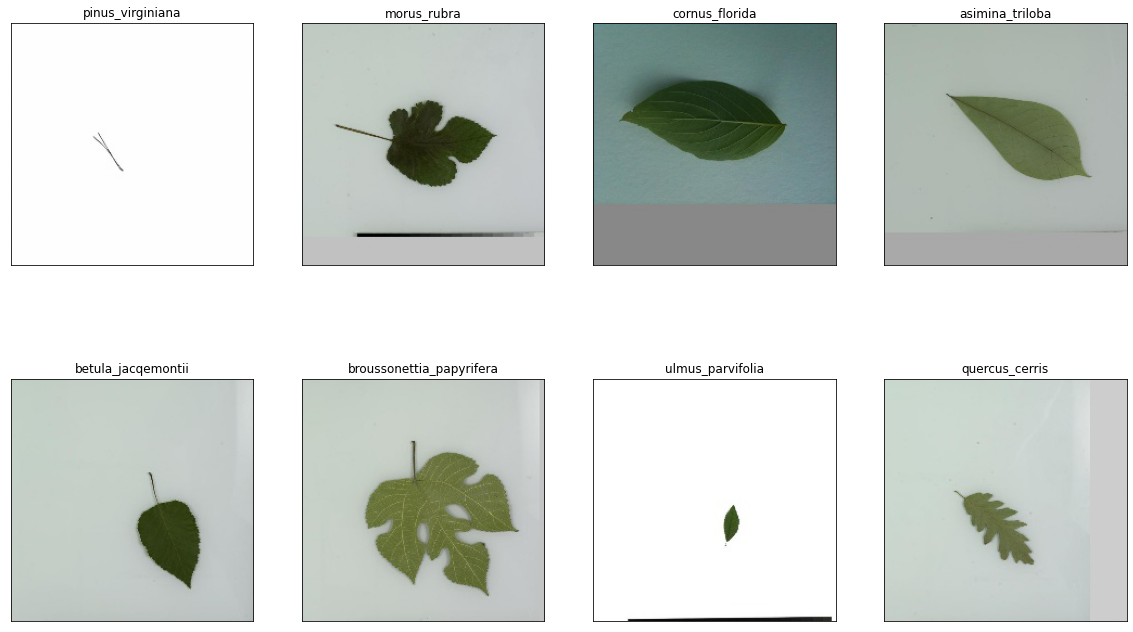

In [13]:
#然后可以看一下数据是什么样子的
def img_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image.clip(0,1)

    return image

fig=plt.figure(figsize=(20,12))
columns=4
rows=2

dataiter=iter(valid_loader)
inputs,classes=dataiter.next()

for idx in range(columns*rows):
    ax=fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(img_convert(inputs[idx]))

plt.show()

In [14]:
#看看是在cpu还是gpu上面跑的
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device=get_device()
print(device)

cpu


In [15]:
#是否要冻住模型的前面一些层
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        model=model
        for param in model.parameters():
            param.requires_grad=False

#resnet34模型
def res_model(num_classes,feature_extract=False,use_pretrained=True):
    model_ft=models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extract)
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Sequential(nn.Linear(num_ftrs,num_classes))

    return model_ft

In [16]:
#超参数的设置
lr=3e-4
weight_decay=1e-3
num_epoch=50
model_path='../classify-leaces/pre_res_model.ckpt'

In [ ]:
#初始化一个模型 并把它放在cpu或者gpu上 
#这里的176是指总共有176个类
model =res_model(176)
model=model.to(device)
model.device=device
#对于分类任务的话我们使用交叉熵计算损失
criterion=nn.CrossEntropyLoss()

#初始化一个优化器，自己可以微调一些超参数
optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

#训练周期数
num_epoch=num_epoch

best_acc=0.0

for epoch in range(num_epoch):
    #--------------------训练----------------------------------------
    #保证模型在训练之前处于训练模式
    model.train()
    #以下两个变量记录训练过程中的信息
    train_loss=[]
    train_acc=[]

    #迭代训练集
    for batch in tqdm(train_loader):
        #一个batch包含图片和对应的标签
        imgs,labels=batch
        imgs=imgs.to(device)
        labels=labels.to(device)

        #通过网络处理imgs
        logits=model(imgs)
        #计算交叉熵
        loss=criterion(logits,labels)
        
        #清除之前的梯度值
        optimizer.zero_grad()
        #计算梯度
        loss.backward()
        #更新参数
        optimizer.step()

        #计算当前batch的准确率 因为经过resnet输出的是一个176列的softmax 其中最大的对应的就是他的类 看是否等于label
        acc=(logits.argmax(dim=-1)==labels).float().mean()

        #记录损失和精度
        train_loss.append(loss.item())
        train_acc.append(acc)

    #计算平均损失和精度
    train_loss=sum(train_loss)/len(train_loss)
    train_acc=sum(train_acc)/len(train_acc)

    #打印提示信息
    print(f'训练周期：{epoch+1:03d}/{num_epoch:03d} 训练损失：{train_loss:.5f} 训练精度：{train_acc:.5f}')




    #--------------------------------验证----------------------------------
    #确保模型处于评估模式
    model.eval()

    valid_loss=[]
    valid_acc=[]

    for batch in tqdm(valid_loader):
        imgs,labels =batch
        #在验证集中不需要使用到梯度
        with torch.no_grad():
            logits=model(imgs.to(device))

        #计算损失
        loss=criterion(logits,labels)

        #计算当前batch的精度
        acc=(logits.argmax(dim=-1)==labels.to(device)).float().mean()

        #记录损失和精度
        valid_loss.append(loss.item())
        valid_acc.append(acc)

    #计算平均损失和精度
    valid_loss=sum(valid_loss)/len(valid_loss)
    valid_acc=sum(valid_acc)/len(valid_acc)

    #打印提示信息
    print(f'验证周期：{epoch+1:03d}/{num_epoch:03d} 验证损失：{valid_loss:.5f} 验证精度：{valid_acc:.5f}')

    #对最佳验证精度做一个记载
    if valid_acc >best_acc:
        best_acc=valid_acc
        torch.save(model.state_dict(),model_path)
        print('正在保存精度为{:.3f}的模型'.format(best_acc))

    
